In [1]:
from matplotlib.gridspec import GridSpec
from netCDF4 import Dataset
import matplotlib
import matplotlib.cm as cm 
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.colors
import matplotlib.colors as colors
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from matplotlib.colors import LogNorm
import numpy as np
from datetime import datetime, timedelta
import datetime as dt
import xarray as xr
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import matplotlib.colors as mcols
import glob 
import colorcet as cc
import netCDF4
import cmaps
from scipy.interpolate import interp2d
import cartopy
import cartopy.crs as ccrs
from cartopy.feature import NaturalEarthFeature
import matplotlib.gridspec as gridspec
import seaborn as sns
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from pyproj import Proj
# from wrf import getvar, interplevel, to_np, latlon_coords, get_cartopy, cartopy_xlim, cartopy_ylim
from colorspacious import cspace_converter
import pathlib
from pathlib import Path
import numpy.ma as ma
from numpy import genfromtxt
import pandas as pd
import calendar
from IPython.core.pylabtools import figsize
from scipy import stats
import sys
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import os

## Objective
This notebook analyzes the rainfall under ARs that make landfall in WA. The output should be a csv that has the following contents:
1. We first take the median rainfall under the AR mask when it makes landfall. Then for all the times under the AR, we average those values and get that output for the AR
2. Second, we take the max rainfall under the AR mask when it makes landfall. Then for all the times under the AR, we average those values as well

We're going to take 24-hour accumulations every 6 hours for this data (can also do them every 24 hours). 6 hours would be too often for accumulations, but since we're taking an average this is probably better

In [98]:
#read in the data
#change to your own personal directory!
#this is just the rain, not the rain filtered!

fn_start_1 = sorted(glob.glob('/home/disk/orca/csmall3/HW_stuff/MLGeo_2023/Final_Project/Rain_nc/Acc_24hr_AR_only/lptid*00.nc'))
fn_start_2 = sorted(glob.glob('/home/disk/orca/csmall3/HW_stuff/MLGeo_2023/Final_Project/Rain_nc/Acc_24hr_AR_only/lptid*06.nc'))
fn_start_3 = sorted(glob.glob('/home/disk/orca/csmall3/HW_stuff/MLGeo_2023/Final_Project/Rain_nc/Acc_24hr_AR_only/lptid*12.nc'))
fn_start_4 = sorted(glob.glob('/home/disk/orca/csmall3/HW_stuff/MLGeo_2023/Final_Project/Rain_nc/Acc_24hr_AR_only/lptid*18.nc'))

fn_start_tot = fn_start_1 + fn_start_2 + fn_start_3 +fn_start_4

In [76]:
#need to split the text such that we only get one-by-one for each AR
NNNN=112
t_len = len(str(fn_start_tot[0]))
hrrr=str(fn_start_tot[0])[t_len - NNNN:]
TT =98 #this extends the end of the string
# str(hrrr)[:TT]
title = str(hrrr)[:TT]

In [77]:
title

'/home/disk/orca/csmall3/HW_stuff/MLGeo_2023/Final_Project/Rain_nc/Acc_24hr_AR_only/lptid00000.1000'

In [62]:
#set up another one for the times and the nc
#don't actually need this but might be helpful later
# ZZZZ=13
# z_len = len(str(fn_start_tot[0]))
# hzzz=str(fn_start_tot[0])[z_len - ZZZZ:]
# UU =15 #this extends the end of the string
# str(hrrr)[:TT]
# title_end = str(hzzz)[:UU]

In [38]:
#try glob with this
test_glob_1 = sorted(glob.glob(title+'*00.nc')) 
test_glob_2 = sorted(glob.glob(title+'*06.nc')) 
test_glob_3 = sorted(glob.glob(title+'*12.nc')) 
test_glob_4 = sorted(glob.glob(title+'*18.nc')) 
test_glob = test_glob_1 + test_glob_2 + test_glob_3 + test_glob_4

In [39]:
test_glob

['/home/disk/orca/csmall3/HW_stuff/MLGeo_2023/Final_Project/Rain_nc/Acc_24hr_AR_only/lptid00000.1000_2017050300.nc',
 '/home/disk/orca/csmall3/HW_stuff/MLGeo_2023/Final_Project/Rain_nc/Acc_24hr_AR_only/lptid00000.1000_2017050400.nc',
 '/home/disk/orca/csmall3/HW_stuff/MLGeo_2023/Final_Project/Rain_nc/Acc_24hr_AR_only/lptid00000.1000_2017050306.nc',
 '/home/disk/orca/csmall3/HW_stuff/MLGeo_2023/Final_Project/Rain_nc/Acc_24hr_AR_only/lptid00000.1000_2017050312.nc',
 '/home/disk/orca/csmall3/HW_stuff/MLGeo_2023/Final_Project/Rain_nc/Acc_24hr_AR_only/lptid00000.1000_2017050118.nc',
 '/home/disk/orca/csmall3/HW_stuff/MLGeo_2023/Final_Project/Rain_nc/Acc_24hr_AR_only/lptid00000.1000_2017050318.nc']

In [140]:
tot_title = []
biased_titie = [] #just the file name for easy filtering
date_rains = []
ar_med_prcp_ovr = []
ar_max_prcp_ovr = []

for i in fn_start_tot:
    #need to figure out how to not repeat these over and over
    NNNN=112
    t_len = len(str(i))
    hrrr=str(i)[t_len - NNNN:]
    TT =98 #this extends the end of the string
    # str(hrrr)[:TT]
    title = str(hrrr)[:TT]

    test_glob_1 = sorted(glob.glob(title+'*00.nc')) 
    test_glob_2 = sorted(glob.glob(title+'*06.nc')) 
    test_glob_3 = sorted(glob.glob(title+'*12.nc')) 
    test_glob_4 = sorted(glob.glob(title+'*18.nc')) 
    test_glob = test_glob_1 + test_glob_2 + test_glob_3 + test_glob_4

    ar_med_prcp = []
    ar_max_prcp = []
    for j in test_glob:

        ar_oi = xr.open_dataset(j)
        rain_ary = ar_oi['One Day Rain'][0].values
        
        rain_ary[rain_ary <= 0] = np.nan
        ar_med_prcp += [np.nanmedian(rain_ary)]
        ar_max_prcp += [np.nanmax(rain_ary)]

    tot_title += [i]
    biased_titie += [title]
    ar_test = xr.open_dataset(i)
    date_rains += [ar_test['time'][0].values]
    # ar_med_prcp = np.concatenate(ar_med_prcp)
    # ar_max_prcp = np.concatenate(ar_max_prcp)
    ar_med_prcp_ovr += [np.mean(ar_med_prcp)]
    ar_max_prcp_ovr += [np.mean(ar_max_prcp)]

/home/disk/orca/csmall3/anaconda3/envs/hyco_env/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
<ipython-input-140-a7e364dcef3d>:31: RuntimeWarning: All-NaN slice encountered
  ar_max_prcp += [np.nanmax(rain_ary)]
/home/disk/orca/csmall3/anaconda3/envs/hyco_env/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
<ipython-input-140-a7e364dcef3d>:31: RuntimeWarning: All-NaN slice encountered
  ar_max_prcp += [np.nanmax(rain_ary)]
/home/disk/orca/csmall3/anaconda3/envs/hyco_env/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
<ipython-input-140-a7e364dcef3d>:31: RuntimeWarning: All-NaN slice encountered
  ar_max_prcp += [n

In [144]:
#convert to pandas df
AR_rain_df = pd.DataFrame({'AR ID':biased_titie,
                           'AR Directory':tot_title, 
                           'Date':date_rains,
                               'Median Rain [mm/day]':ar_med_prcp_ovr,
                               'Max Rain [mm/day]':ar_max_prcp_ovr})

#try to reindex to make alphanumeric
AR_rain_df = AR_rain_df.sort_values('AR Directory')
AR_rain_df=AR_rain_df.reset_index(inplace = False)
AR_rain_df = AR_rain_df.drop(columns=['index'])

In [145]:
AR_rain_df

,AR ID,AR Directory,Date,Median Rain [mm/day],Max Rain [mm/day]
0,/home/disk/orca/csmall3/HW_stuff/MLGeo_2023/Fi...,/home/disk/orca/csmall3/HW_stuff/MLGeo_2023/Fi...,2017-05-01 18:00:00,4.261770,12.725850
1,/home/disk/orca/csmall3/HW_stuff/MLGeo_2023/Fi...,/home/disk/orca/csmall3/HW_stuff/MLGeo_2023/Fi...,2017-05-03 00:00:00,4.261770,12.725850
2,/home/disk/orca/csmall3/HW_stuff/MLGeo_2023/Fi...,/home/disk/orca/csmall3/HW_stuff/MLGeo_2023/Fi...,2017-05-03 06:00:00,4.261770,12.725850
3,/home/disk/orca/csmall3/HW_stuff/MLGeo_2023/Fi...,/home/disk/orca/csmall3/HW_stuff/MLGeo_2023/Fi...,2017-05-03 12:00:00,4.261770,12.725850
4,/home/disk/orca/csmall3/HW_stuff/MLGeo_2023/Fi...,/home/disk/orca/csmall3/HW_stuff/MLGeo_2023/Fi...,2017-05-03 18:00:00,4.261770,12.725850
...,...,...,...,...,...
556,/home/disk/orca/csmall3/HW_stuff/MLGeo_2023/Fi...,/home/disk/orca/csmall3/HW_stuff/MLGeo_2023/Fi...,2017-04-05 18:00:00,33.541255,53.456751
557,/home/disk/orca/csmall3/HW_stuff/MLGeo_2023/Fi...,/home/disk/orca/csmall3/HW_stuff/MLGeo_2023/Fi...,2017-04-30 00:00:00,4.818630,16.253717
558,/home/disk/orca/csmall3/HW_stuff/MLGeo_2023/Fi...,/home/disk/orca/csmall3/HW_stuff/MLGeo_2023/Fi...,2017-04-30 06:00:00,4.818630,16.253717
559,/home/disk/orca/csmall3/HW_stuff/MLGeo_2023/Fi...,/home/disk/orca/csmall3/HW_stuff/MLGeo_2023/Fi...,2017-04-30 00:00:00,4.818630,16.253717


In [104]:
AR_rain_df['AR ID'].iloc[1]

'/home/disk/orca/csmall3/HW_stuff/MLGeo_2023/Final_Project/Rain_nc/Acc_24hr_AR_only/lptid00000.1000_2017050400.nc'

In [156]:
#drop the duplicates so we only have the AR data we need
clean_ARs=AR_rain_df.drop_duplicates(subset=['AR ID']).reset_index()
clean_ARs = clean_ARs.drop(columns=['index'])

In [157]:
clean_ARs

,AR ID,AR Directory,Date,Median Rain [mm/day],Max Rain [mm/day]
0,/home/disk/orca/csmall3/HW_stuff/MLGeo_2023/Fi...,/home/disk/orca/csmall3/HW_stuff/MLGeo_2023/Fi...,2017-05-01 18:00:00,4.261770,12.725850
1,/home/disk/orca/csmall3/HW_stuff/MLGeo_2023/Fi...,/home/disk/orca/csmall3/HW_stuff/MLGeo_2023/Fi...,2017-05-01 18:00:00,1.788149,1.788149
2,/home/disk/orca/csmall3/HW_stuff/MLGeo_2023/Fi...,/home/disk/orca/csmall3/HW_stuff/MLGeo_2023/Fi...,2014-05-08 18:00:00,31.752396,38.495197
3,/home/disk/orca/csmall3/HW_stuff/MLGeo_2023/Fi...,/home/disk/orca/csmall3/HW_stuff/MLGeo_2023/Fi...,2015-08-31 06:00:00,2.472309,11.936662
4,/home/disk/orca/csmall3/HW_stuff/MLGeo_2023/Fi...,/home/disk/orca/csmall3/HW_stuff/MLGeo_2023/Fi...,2014-05-21 12:00:00,9.437957,20.627537
...,...,...,...,...,...
80,/home/disk/orca/csmall3/HW_stuff/MLGeo_2023/Fi...,/home/disk/orca/csmall3/HW_stuff/MLGeo_2023/Fi...,2016-04-06 06:00:00,11.197525,12.862860
81,/home/disk/orca/csmall3/HW_stuff/MLGeo_2023/Fi...,/home/disk/orca/csmall3/HW_stuff/MLGeo_2023/Fi...,2015-04-27 06:00:00,4.148093,7.159547
82,/home/disk/orca/csmall3/HW_stuff/MLGeo_2023/Fi...,/home/disk/orca/csmall3/HW_stuff/MLGeo_2023/Fi...,2017-04-05 00:00:00,33.541255,53.456751
83,/home/disk/orca/csmall3/HW_stuff/MLGeo_2023/Fi...,/home/disk/orca/csmall3/HW_stuff/MLGeo_2023/Fi...,2017-04-30 00:00:00,4.818630,16.253717


In [160]:
clean_ARs['AR Directory'].iloc[1]

'/home/disk/orca/csmall3/HW_stuff/MLGeo_2023/Final_Project/Rain_nc/Acc_24hr_AR_only/lptid00000.2000_2017050118.nc'

In [174]:
#save the data in the CSVs
AR_rain_df.to_csv('/home/disk/orca/csmall3/HW_stuff/MLGeo_2023/Final_Project/text_data/WA_6hrly_rain_stats.csv') 
clean_ARs.to_csv('/home/disk/orca/csmall3/HW_stuff/MLGeo_2023/Final_Project/text_data/WA_FINAL_rain_stats.csv') 

## Plot
This is a pretty bad example of what it looks like since most of the AR is over the Pacific Ocean, but in general since we're averaging for mulitple times it's over land, we capture more information

In [171]:
#rainfall data unfiltered
data_all = xr.open_dataset('/home/disk/orca/csmall3/HW_stuff/MLGeo_2023/Final_Project/Rain_nc/Acc_24hr/lptid00000.2000_2017050118.nc')

#rainfall data filtered under the AR mask and regridded to ERA5
data =xr.open_dataset(clean_ARs['AR Directory'].iloc[1])

#open the AR of interest
ar_oi = xr.open_dataset('/home/disk/orca/csmall3/AR_testing_research/LPT_ARs/hourly_res/10N_10S_AR_outputs/data/AR/g0_0h/thresh1/systems/2017050100_2018043023/lpt_system_mask_AR.lptid00000.2000.nc')
mask_ary=ar_oi['mask_at_end_time'][18]

/home/disk/orca/csmall3/anaconda3/envs/hyco_env/lib/python3.8/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/home/disk/orca/csmall3/anaconda3/envs/hyco_env/lib/python3.8/site-packages/cartopy/crs.py:836: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  line_strings = list(multi_line_string)
/home/disk/orca/csmall3/anaconda3/envs/hyco_env/lib/python3.8/site-packages/cartopy/crs.py:836: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  line_string

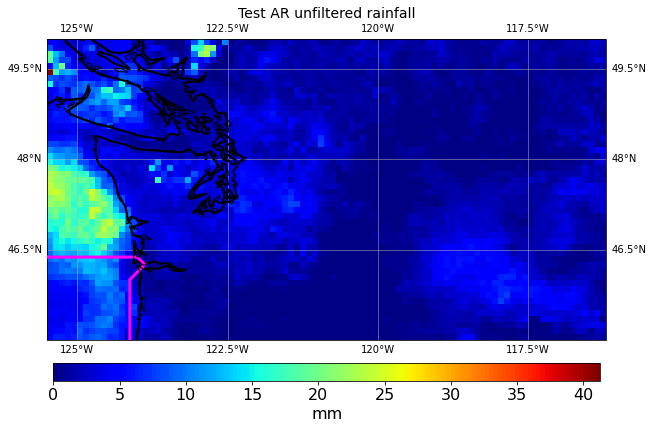

In [172]:
#try plotting this out
plot_data = data_all['One Day Rain'][0]
lon_ary = data_all['lon']
# lat_ary = IMERG_mask['lat'][::-1]# this works lol
lat_ary = data_all['lat']# this works lol
mask_lat = mask_ary['lat']
mask_lon = mask_ary['lon']

colormap=cmaps.MPL_jet
fig = plt.figure(figsize=[14, 7])
political_boundaries = NaturalEarthFeature(category='cultural', name='admin_0_boundary_lines_land', scale='50m', facecolor='none')
states = NaturalEarthFeature(category='cultural', name='admin_1_states_provinces_lakes', scale='50m', facecolor='none')

ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_title('Test AR unfiltered rainfall', fontsize=14)					   
ax.add_feature(cartopy.feature.LAND, edgecolor='k', facecolor='none', zorder=10)
ax.coastlines('50m', linewidth=2, zorder=5)
ax.set_extent([-125.5, -116.2, 45, 50], crs=ccrs.PlateCarree())#set west coast in a second
css = ax.pcolormesh(lon_ary, lat_ary, plot_data.T, cmap = colormap, transform=ccrs.PlateCarree(),zorder=1, vmin=0) #shut of min/max
ax.contour(mask_lon, mask_lat, mask_ary, [0.5], colors=('magenta',), transform=ccrs.PlateCarree(),zorder=5, vmin=0,linewidths=3)
# ax.scatter(240.3, 34.416667, c='r', marker='x', s=100)
#css = ax.pcolormesh(lon_ary, lat_ary, plot_data, cmap = cmaps.precip2_17lev, transform=ccrs.PlateCarree(),zorder=1, vmin=7)
#cbar = plt.colorbar(css, ax=ax, extend='both', shrink=0.75)
#cbar = plt.colorbar(css, ax=ax,orientation='horizontal',extend='min',aspect=30, shrink=0.7, pad=0.06)
cbar = plt.colorbar(css, ax=ax,orientation='horizontal',aspect=30, shrink=0.7, pad=0.06)
cbar.ax.tick_params(labelsize=16)
cbar.set_label('mm', fontsize =16)

#ax.text(20,-135,'Source= IMERG, Units=$mm$ $day^{-1}$', fontsize = 12, color = 'k')

#try adding gridlines
gl = ax.gridlines(draw_labels=True, linewidth=0.5)
gl.ypadding = 5
gl.xpadding = 5
gl.xlocator = mticker.FixedLocator(np.arange(-180,180,2.5)[::1])
gl.ylocator = mticker.FixedLocator(np.arange(-90,90,1.5)[::1])		
fig.show()

<ipython-input-173-44593ed6b589>:36: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


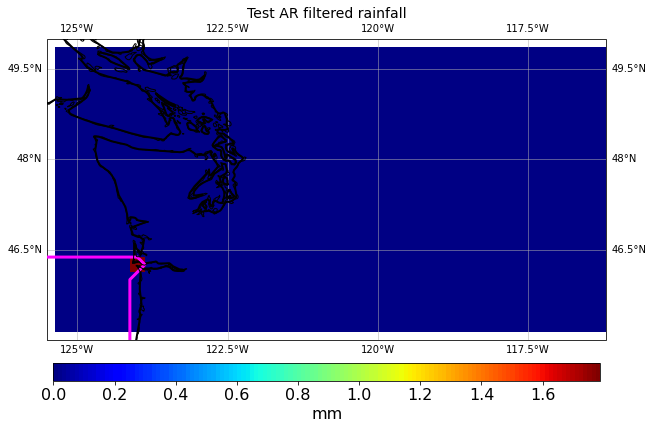

In [173]:
#try plotting this out
plot_data = data['One Day Rain'][0]
lon_ary = data['lon']
# lat_ary = IMERG_mask['lat'][::-1]# this works lol
lat_ary = data['lat']# this works lol


colormap=cmaps.MPL_jet
fig = plt.figure(figsize=[14, 7])
political_boundaries = NaturalEarthFeature(category='cultural', name='admin_0_boundary_lines_land', scale='50m', facecolor='none')
states = NaturalEarthFeature(category='cultural', name='admin_1_states_provinces_lakes', scale='50m', facecolor='none')

ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_title('Test AR filtered rainfall', fontsize=14)					   
ax.add_feature(cartopy.feature.LAND, edgecolor='k', facecolor='none', zorder=10)
ax.coastlines('50m', linewidth=2, zorder=5)
ax.set_extent([-125.5, -116.2, 45, 50], crs=ccrs.PlateCarree())#set west coast in a second
css = ax.pcolormesh(lon_ary, lat_ary, plot_data.T, cmap = colormap, transform=ccrs.PlateCarree(),zorder=1, vmin=0) #shut of min/max
ax.contour(mask_lon, mask_lat, mask_ary, [0.5], colors=('magenta',), transform=ccrs.PlateCarree(),zorder=5, vmin=0,linewidths=3)
# ax.scatter(240.3, 34.416667, c='r', marker='x', s=100)
#css = ax.pcolormesh(lon_ary, lat_ary, plot_data, cmap = cmaps.precip2_17lev, transform=ccrs.PlateCarree(),zorder=1, vmin=7)
#cbar = plt.colorbar(css, ax=ax, extend='both', shrink=0.75)
#cbar = plt.colorbar(css, ax=ax,orientation='horizontal',extend='min',aspect=30, shrink=0.7, pad=0.06)
cbar = plt.colorbar(css, ax=ax,orientation='horizontal',aspect=30, shrink=0.7, pad=0.06)
cbar.ax.tick_params(labelsize=16)
cbar.set_label('mm', fontsize =16)

#ax.text(20,-135,'Source= IMERG, Units=$mm$ $day^{-1}$', fontsize = 12, color = 'k')

#try adding gridlines
gl = ax.gridlines(draw_labels=True, linewidth=0.5)
gl.ypadding = 5
gl.xpadding = 5
gl.xlocator = mticker.FixedLocator(np.arange(-180,180,2.5)[::1])
gl.ylocator = mticker.FixedLocator(np.arange(-90,90,1.5)[::1])		
fig.show()